# AOS 51, Fall 2018, Lab #4

So far we have plotted maps with built-in `xarray` commands. Today, we'll learn how to formally create beautiful maps using `cartopy`.

---

In [13]:
# import all the packages we need
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Cartopy setup

We generally want to display state/province boundaries in our maps. To do that, we first need to load built-in shapefiles containing these boundaries:

In [15]:
# Adding State/Province boundaries with built-in Cartopy features
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

With the boundaries loaded, we can return to `matplotlib` and follow the usual plot creation steps:

* Creating a figure canvas that will contain our map(s)
   * `fig = plt.figure(figsize=(8,4))`
* Adding a subplot to the figure canvas, establish the subplot grid (row #, col #, subplot #), and define our axes to be a GeoAxes using the [PlateCarree](https://en.wikipedia.org/wiki/Equirectangular_projection) map projection
   * `ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())`

Then, we need to create a geo-axes with a defined map projection (e.g.  and overlay state boundaries along with coastlines and geographic borders. 

* Overlay boundaries
   * `ax.coastlines(resolution='50m')` (can be 110, 50, or 10m resolution; can also specify the color) 
   * `ax.gridlines(draw_labels=True)`
   * `ax.add_feature(states_provinces, edgecolor='black')`
   * `ax.add_feature(cfeature.BORDERS)`

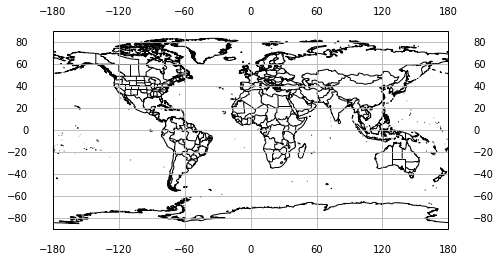

In [16]:
# Most basic map: no data, just display the PlateCarree projection 
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.coastlines(resolution='50m') #can be 110, 50, or 10m resolution; can also specify the color 
ax.gridlines(draw_labels=True)
ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

### Mapping climate data

Let's make maps of skin temperature data from the NCEP-DOE II reanalyses used in the previous lab. 

In [18]:
# Change the path to wherever you have stored this netcdf file
ncfile = xr.open_dataset('/Users/nberg/AOS51/data/skt_sfc_mon_mean_1998_2017.nc')
skt = ncfile['skt'] # extract skin temperature 
skt_avg = skt.mean(dim='time') # calculate the temporal average
skt_avg

<xarray.DataArray 'skt' (lat: 94, lon: 192)>
array([[ 229.02005 ,  228.843018,  228.665039, ...,  229.550613,  229.374283,
         229.197113],
       [ 230.975601,  230.553925,  230.133957, ...,  232.236679,  231.817932,
         231.397141],
       [ 232.157913,  231.545944,  230.939285, ...,  234.02504 ,  233.397858,
         232.77594 ],
       ..., 
       [ 257.530334,  257.668549,  257.76062 , ...,  257.194214,  257.293274,
         257.450867],
       [ 257.464294,  257.507355,  257.568878, ...,  257.281158,  257.344269,
         257.428772],
       [ 257.142639,  257.287567,  257.277771, ...,  257.226166,  257.262543,
         257.10553 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -88.542 -86.6531 -84.7532 -82.8508 -80.9473 ...
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...

With a 2D dataset now (lat x lon), we can make a map!

### Contouring and filling data over the map (contourf)

Text(0.5,1,'SKT contours')

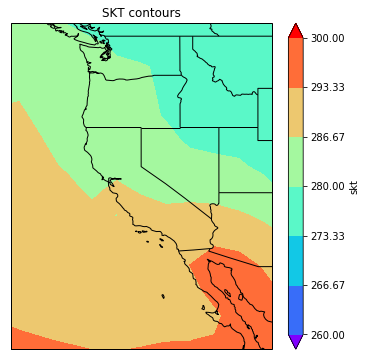

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

# Contour and fill average skin temperature
# vmin and vmax set the min/max values on the colorbar 
skt_avg.plot.contourf(ax=ax, 
                      transform=ccrs.PlateCarree(), 
                      cmap='rainbow', 
                      vmin=260, vmax=300)

# zoom in over the Western US by setting(x0, x1, y0, y1) of the map in the given coordinate system.
ax.set_extent([230,250,25,50]) 

# Overlay the coastlines/boundaries/borders
ax.coastlines('50m')
ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)
ax.set_title('SKT contours')

### Grid-cell colormesh over the map (pcolormesh)

To not smooth across pixels and instead display each pixel's value, we can use `pcolormesh` instead of `contourf`:

Text(0.5,1,'SKT colormesh')

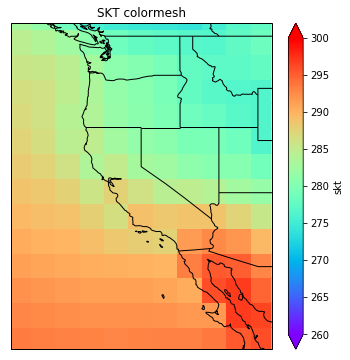

In [7]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

# Pixelated map using pcolormesh instead of contourf
skt_avg.plot.pcolormesh(ax=ax, 
                        transform=ccrs.PlateCarree(), 
                        cmap='rainbow', 
                        vmin=260, vmax=300)

ax.set_extent([230,250,25,50])
ax.coastlines('50m')
ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)
ax.set_title('SKT colormesh')

** -- In-class exercise -- **

1. Resample the monthly-mean skin temperature data to annual-means.
2. Extract 2001-2010 data and compute the 10-year average.
3. Create a map showing 2001-2010 average skin temperature across the globe. 

Text(0.5,1,'SKT 2001-2010')

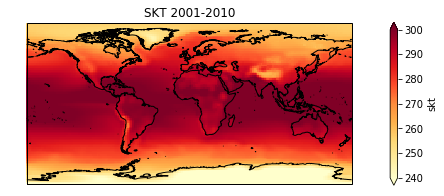

In [8]:
skt_2001_2010_avg = skt.resample(time='AS').mean(dim='time').sel(time=slice('2001','2010')).mean(dim='time')

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

# Can use pcolormesh or contourf
skt_2001_2010_avg.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='YlOrRd', vmin=240, vmax=300)

ax.coastlines('50m')
#ax.add_feature(states_provinces, edgecolor='black')
#ax.add_feature(cfeature.BORDERS)
ax.set_title('SKT 2001-2010')

### Multi-panel maps

For multi-panel maps, we simply need to define multiple axes (`ax`) as we would normally do in matplotlib.

In [9]:
# Compute DJF and JJA average temperatures
skt_djf_avg = skt.groupby('time.season').mean('time').sel(season='DJF')
skt_jja_avg = skt.groupby('time.season').mean('time').sel(season='JJA')

Text(0.5,1,'SKT JJA average')

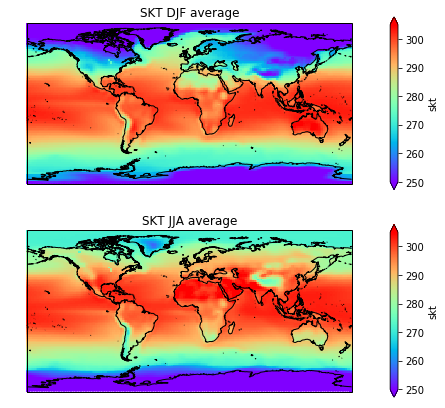

In [10]:
# 2-panel figure (2 rows, 1 column)
fig = plt.figure(figsize=(8,7))

ax1 = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())

skt_djf_avg.plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), cmap='rainbow', vmin=250, vmax=305)

ax1.coastlines('50m')
#ax1.add_feature(states_provinces, edgecolor='black')
#ax1.add_feature(cfeature.BORDERS)
ax1.set_title('SKT DJF average')

ax2 = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())

skt_jja_avg.plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), cmap='rainbow', vmin=250, vmax=305)

ax2.coastlines('50m')
#ax2.add_feature(states_provinces, edgecolor='black')
#ax2.add_feature(cfeature.BORDERS)
ax2.set_title('SKT JJA average')

** -- In-class exerdcise -- **

1. Calculate spring (MAM) and fall (SON) mean temperatures.
2. Create a two-panel plot (2 rows and 1 column) displaying MAM and OND average temperatures. 

Text(0.5,1,'SKT SON average')

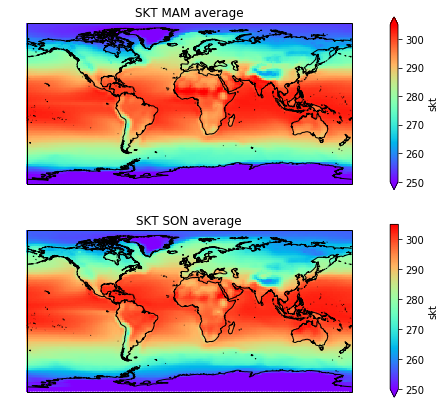

In [70]:
# Compute MAM and OND average temperatures
skt_mam_avg = skt.groupby('time.season').mean('time').sel(season='MAM')
skt_son_avg = skt.groupby('time.season').mean('time').sel(season='SON')

# 2-panel figure (1 row, 2 columns)
fig = plt.figure(figsize=(8,7))

ax1 = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())

skt_mam_avg.plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), cmap='rainbow', vmin=250, vmax=305)

ax1.coastlines('50m')
#ax1.add_feature(states_provinces, edgecolor='black')
#ax1.add_feature(cfeature.BORDERS)
ax1.set_title('SKT MAM average')

ax2 = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())

skt_son_avg.plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), cmap='rainbow', vmin=250, vmax=305)

ax2.coastlines('50m')
#ax2.add_feature(states_provinces, edgecolor='black')
#ax2.add_feature(cfeature.BORDERS)
ax2.set_title('SKT SON average')

** -- In-class exercise -- **

1. Compute monthly average temperature for January, April, July, and October.
2. Create a 4-panel plot (2 rows x 2 columns) display these monthly average temperatures *over the United States*. 

Text(0.5,1,'SKT October average')

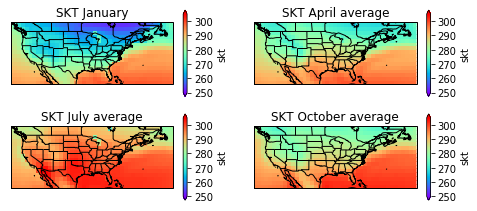

In [12]:
# Compute Jan, April, July, and October average temps
skt_jan_avg = skt.groupby('time.month').mean('time').sel(month=1)
skt_apr_avg = skt.groupby('time.month').mean('time').sel(month=4)
skt_jul_avg = skt.groupby('time.month').mean('time').sel(month=7)
skt_oct_avg = skt.groupby('time.month').mean('time').sel(month=10)

# 4-panel figure (2 rows, 2 columns)
fig = plt.figure(figsize=(8,3.5))

ax1 = fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
skt_jan_avg.plot.pcolormesh(ax=ax1, 
                            transform=ccrs.PlateCarree(), 
                            cmap='rainbow', 
                            vmin=250, vmax=305)
ax1.set_extent([230,310,23,46])
ax1.coastlines('50m')
ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cfeature.BORDERS)
ax1.set_title('SKT January')

ax2 = fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
skt_apr_avg.plot.pcolormesh(ax=ax2, 
                            transform=ccrs.PlateCarree(), 
                            cmap='rainbow', 
                            vmin=250, vmax=305)
ax2.set_extent([230,310,23,46])
ax2.coastlines('50m')
ax2.add_feature(states_provinces, edgecolor='black')
ax2.add_feature(cfeature.BORDERS)
ax2.set_title('SKT April average')

ax3 = fig.add_subplot(2,2,3, projection=ccrs.PlateCarree())
skt_jul_avg.plot.pcolormesh(ax=ax3, 
                            transform=ccrs.PlateCarree(), 
                            cmap='rainbow', 
                            vmin=250, vmax=305)
ax3.set_extent([230,310,23,46])
ax3.coastlines('50m')
ax3.add_feature(states_provinces, edgecolor='black')
ax3.add_feature(cfeature.BORDERS)
ax3.set_title('SKT July average')

ax4 = fig.add_subplot(2,2,4, projection=ccrs.PlateCarree())
skt_oct_avg.plot.pcolormesh(ax=ax4, 
                            transform=ccrs.PlateCarree(), 
                            cmap='rainbow', 
                            vmin=250, vmax=305)
ax4.set_extent([230,310,23,46])
ax4.coastlines('50m')
ax4.add_feature(states_provinces, edgecolor='black')
ax4.add_feature(cfeature.BORDERS)
ax4.set_title('SKT October average')